In [65]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

df_clean = pd.read_csv('../data/clean.csv')

# Logistic Regression Model (w/all Selected Features)

In [66]:
df_clean['classification'].value_counts()

classification
1    161
0    132
Name: count, dtype: int64

**The data is ~55-45 distributed for classification counts, making it approximately even, which is ideal.**

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df_clean[['hemo', 'sc', 'htn', 'dm', 'bp', 'bgr', 'age']]
y = df_clean['classification']

**The variables chosen as the x input for the initial regression were the variables of interest graphed in the EDA. These variables all displayed a p < 0.0001 significance between the variables and are readily available from basic medical equipment, a blood test, and a medical history. Variables with multicollinearity were excluded (blood urea and serum creatinine), and clinical variables known for their strong association with CKD were selected.**

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 18,
    stratify = y
)

**80-20 train-test split is standard, random state 18 is used in all models in this project for comparability and reproducability, and stratifying y makes sure the train and test groups mirror the original distribution (~55-45).**

In [69]:
model = LogisticRegression(
    C = 1, 
    penalty = 'l2',
    solver='lbfgs', 
    max_iter = 200,
    random_state = 18,
)

# The distribution is 161-132, which is slightly imbalanced; I tried class_weight = 'balanced' but yielded slightly lower scores, so I stuck to none. 

model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,18
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


**The hyperparameters were chosen in a way to make sure the model does not memorize the data and overfit to it (espcially with a 300 sample dataset), so it still has generalizability. To do this, an L2 penalty was chosen (which lbfgs, a standard solver, supports). Inverse regularization strength (C) was kept at the default value 1 to prevent over or underfitting (might need to be optimized in the future).**

In [70]:
y_predict = model.predict(X_test)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.94      0.97        32

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59



In [71]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=3, scoring='accuracy')
print("Accuracy per Fold:", scores)
print("Mean accuracy:", np.mean(scores))

# Couldn't do greater than cv = 3 since it causes a convergence error w/max iterations & the lbfgs solver

Accuracy per Fold: [0.96938776 0.94897959 0.98969072]
Mean accuracy: 0.96935268952942


**A few folds of cross-validation are also displayed (limited to 3 due to the max iteration parameter), which shows that the classification report values are not purely based on chance.**

# Feature Importances

In [72]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
})

feature_importance['AbsCoeff'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='AbsCoeff', ascending=False)
feature_importance

,Feature,Coefficient,AbsCoeff
0,hemo,-1.630278,1.630278
1,sc,1.623967,1.623967
3,dm,1.351329,1.351329
2,htn,1.180847,1.180847
4,bp,0.057415,0.057415
5,bgr,0.048923,0.048923
6,age,-0.032411,0.032411


**From the table, the model weighs hemoglobin and serum creatinine the highest, which aligns with our predictions. The model also seems to prefer categorical variables (htn and dm) over their quantitative counterparts (bp and bgr). This needs further examination (will explore with SVM), but it makes sense that the model would prefer a chronic condition diagnosis (very telling) to noisy variables that fluctuate frequently. The quantitative variables may even be a form of secondary validation if the model is unsure.**

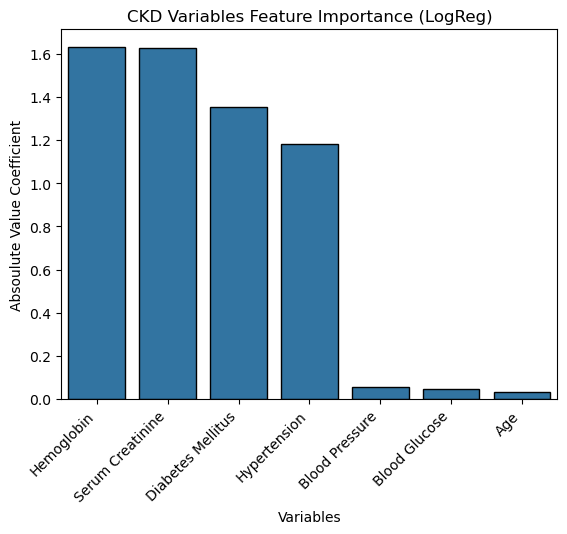

In [92]:
sns.barplot(
    data = feature_importance,
    x = 'Feature',
    y = 'AbsCoeff',
    capsize=0.2,
    edgecolor='black'
)
plt.title('CKD Variables Feature Importance (LogReg)')
plt.xlabel('Variables')
plt.ylabel('Absoulute Value Coefficient')
plt.xticks(['htn', 'sc', 'hemo', 'bp', 'age', 'bgr', 'dm'], ["Hypertension", "Serum Creatinine", "Hemoglobin", "Blood Pressure", "Age", "Blood Glucose", "Diabetes Mellitus"])
plt.xticks(rotation=45, ha="right")
plt.savefig("../figures/feature_importance/LogReg_Feature_Importance.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve & AUC Score

In [74]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"AUC Score: {round(roc_auc, 4)}")

AUC Score: 0.9954


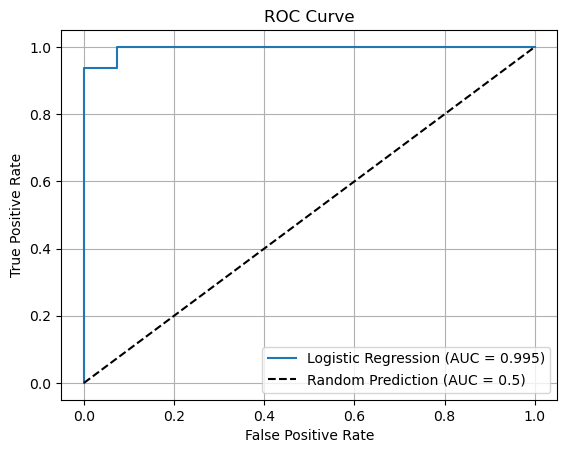

In [93]:
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Prediction (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig("../figures/roc_auc/LogReg_ROC.png", dpi=300, bbox_inches='tight')
plt.show()

**The model has a very high AUC score, but it's important to note that this needs to be confirmed with other models since overfitting is a possibility, especially due to the dataset being 300 samples. Still, it gives us a lot of insight about the disease and crutial information for potentially flagging at risk patients, even if limited to the region where the data was collected.**

# Classification Threshold Optimization

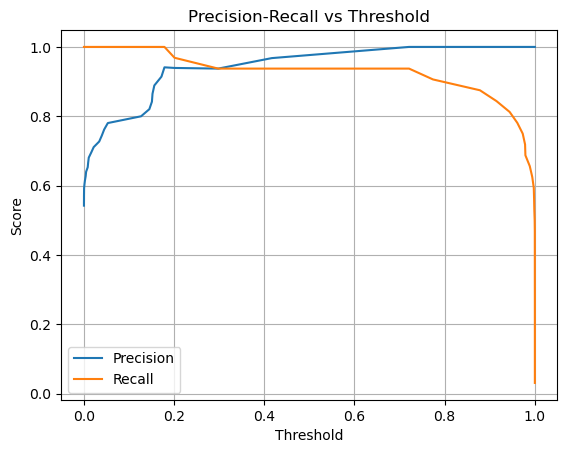

In [94]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.savefig("../figures/logreg/LogReg_Precision-Recall.png", dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

**In clinical environments, flagging all possible CKD positive classifications for further testing is far more important than a few extra false positives (which are technically harmless in comparison). With this in mind, the classification threshold needs to be dropped from 0.5 (the default) so that recall is as close to 1 as possible, as long as too much precision isn't being sacrificed for it.**

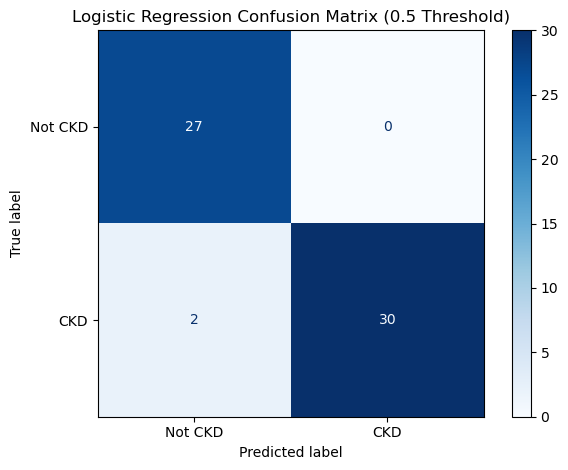

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matrix1 = confusion_matrix(y_test, y_predict, labels = [0,1])

display1 = ConfusionMatrixDisplay(confusion_matrix = matrix1, display_labels= ["Not CKD", "CKD"])
display1.plot(cmap ='Blues')
plt.title("Logistic Regression Confusion Matrix (0.5 Threshold)")
plt.tight_layout()
plt.savefig("../figures/logreg/LogReg_CMatrix_(0.5).png", dpi=300, bbox_inches='tight')
plt.show()

**The Confusion Matrix shows that the test data has 2 false negatives and 0 false positives. Ideally, we want the false negatives to be 0.**

In [78]:
threshold = 0.175
y_predict_2 = (y_proba >= threshold).astype(int)

print(y_predict_2)

[1 1 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0
 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0]


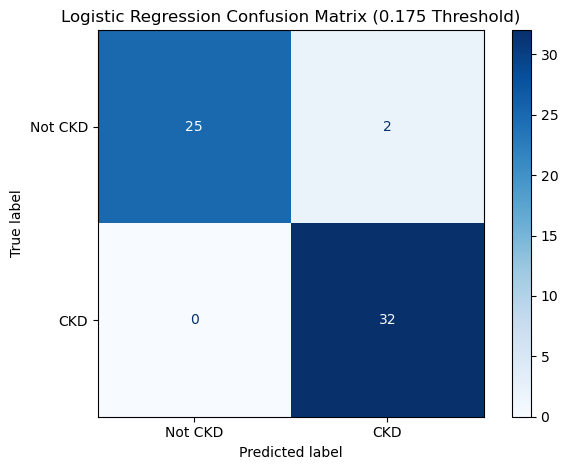

In [96]:
matrix2 = confusion_matrix(y_test, y_predict_2, labels = [0,1])

display2 = ConfusionMatrixDisplay(confusion_matrix = matrix2, display_labels= ["Not CKD", "CKD"])
display2.plot(cmap ='Blues')
plt.title("Logistic Regression Confusion Matrix (0.175 Threshold)")
plt.tight_layout()
plt.savefig("../figures/logreg/LogReg_CMatrix_(0.175).png", dpi=300, bbox_inches='tight')
plt.show()

**Since our data was small, with some graphical analysis and guess and check, we were able to trade the 2 false negatives for 2 false positives, which is the best-case scenario. But once more datasets are implemented in the future, more rigorous optimization functions will need to be used to get an exact threshold value, since it won't be as simple.**

In [80]:
print(classification_report(y_test, y_predict_2))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        27
           1       0.94      1.00      0.97        32

    accuracy                           0.97        59
   macro avg       0.97      0.96      0.97        59
weighted avg       0.97      0.97      0.97        59



# Calibration Curve

**A calibration curve helps us determine if the predicted probabilities align with the actual outcomes. In the case of our dataset, n_bins was set to 6 (~10 samples per bin) and the quantile strategy was used to assess the model. The small dataset is definitely a limitation (resulting in fewer bins to limit noise), but with these hyperparameters in place, we obtain some additional confirmation of model performance nonetheless.**

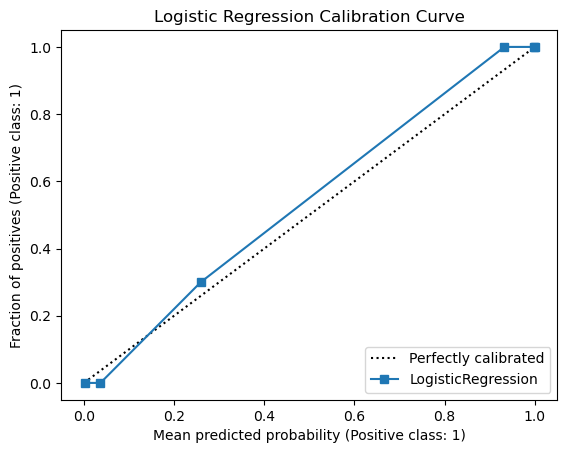

In [97]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_estimator(
    model,
    X_test,
    y_test,
    n_bins = 6,
    strategy = 'quantile'
)
plt.title("Logistic Regression Calibration Curve")
plt.savefig("../figures/calibration/CalibrationCurve(LogReg).png", dpi=300, bbox_inches='tight')
plt.show()

# Limited Model (w/o Chronic Illness Information)

**Some very rural areas might not have as much information, such as medical records. For cases like this, a simplified model using only the top features (hemo and sc) is displayed below. This is because a simple blood test can give you both of them at once. Variables like bp, bgr, and age were not included to showcase how strong hemo and sc are for signals.**

In [82]:
X_1 = df_clean[['hemo', 'sc']]
y_1 = df_clean['classification']

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(
    X_1, y_1,
    test_size = 0.2,
    random_state = 18,
    stratify = y_1
)

model_1 = LogisticRegression(
    C = 1, 
    penalty = 'l2',
    solver='lbfgs', 
    max_iter = 200,
    random_state = 18,
)

model_1.fit(X_1_train, y_1_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,18
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [83]:
y_1_predict = model_1.predict(X_1_test)

print(classification_report(y_1_test, y_1_predict))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        27
           1       1.00      0.91      0.95        32

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59



# Biomarker Sensitivity Check (Creatinine vs Blood Urea)

### Blood Urea (replacing Serum Creatinine)

**Urea was not included in the model since it was highly associated with creatinine (r = 0.75), which can confuse the model due to multicollinearity. Here, serum creatinine will be replaced by blood urea to assess how a different biomarker performs, as well as its impact on performance metrics and feature importances.**

In [84]:
df_urea = df_clean.copy()
df_urea = df_clean.dropna(subset=['bu']).copy()

In [85]:
X_u = df_urea[['hemo', 'bu', 'htn', 'dm', 'bp', 'bgr', 'age']]
y_u = df_urea['classification']

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    X_u, y_u,
    test_size = 0.2,
    random_state = 18,
    stratify = y_u
)

model_u = LogisticRegression(
    C = 1, 
    penalty = 'l2',
    solver='lbfgs', 
    max_iter = 200,
    random_state = 18,
)

model_u.fit(X_train_u, y_train_u)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,18
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [86]:
y_predict_u = model_u.predict(X_test_u)

print(classification_report(y_test_u, y_predict_u))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.94      0.97        32

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59



In [87]:
feature_importance_u = pd.DataFrame({
    'Feature': X_train_u.columns,
    'Coefficient': model_u.coef_[0]
})

feature_importance_u['AbsCoeff'] = feature_importance_u['Coefficient'].abs()
feature_importance_u = feature_importance_u.sort_values(by='AbsCoeff', ascending=False)
feature_importance_u

,Feature,Coefficient,AbsCoeff
0,hemo,-1.604867,1.604867
2,htn,1.391023,1.391023
3,dm,1.330258,1.330258
4,bp,0.057334,0.057334
5,bgr,0.024672,0.024672
1,bu,0.018125,0.018125
6,age,-0.007709,0.007709


**Even though the classification metrics didn't change, that was due to redundancy in the data rather than the blood urea feature itself, as shown by its importance coefficient. This is likely due to how blood urea can easily fluctuate due to other cofunding variables, making it noisy and skewed.**

### Log Transformed Blood Urea-Serum Creatinine Ratio

**In some clinical contexts, a ratio of bu to sc is used to diagnose diseases. Since bu on its own didn't provide much feature importance, a log transform was done to try and reduce the effects of skewness and noise. Another note is that log(bu) and bu/sc combinations were also tried but were ineffective (probably due to the noise in bu), as suspected earlier.**

In [88]:
df_urea['bu_sc_ratio'] = np.log(df_urea['bu'] / df_urea['sc'])

In [89]:
X_r = df_urea[['hemo', 'bu_sc_ratio', 'htn', 'dm', 'bp', 'bgr', 'age']]
y_r = df_urea['classification']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_r, y_r,
    test_size = 0.2,
    random_state = 18,
    stratify = y_r
)

model_r = LogisticRegression(
    C = 1, 
    penalty = 'l2',
    solver='lbfgs', 
    max_iter = 200,
    random_state = 18,
)

model_r.fit(X_train_r, y_train_r)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,18
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [90]:
y_predict_r = model_r.predict(X_test_r)

print(classification_report(y_test_r, y_predict_r))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.94      0.97        32

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59



In [91]:
feature_importance_r = pd.DataFrame({
    'Feature': X_train_r.columns,
    'Coefficient': model_r.coef_[0]
})

feature_importance_r['AbsCoeff'] = feature_importance_r['Coefficient'].abs()
feature_importance_r = feature_importance_r.sort_values(by='AbsCoeff', ascending=False)
feature_importance_r

,Feature,Coefficient,AbsCoeff
0,hemo,-1.683591,1.683591
2,htn,1.636139,1.636139
3,dm,1.327534,1.327534
1,bu_sc_ratio,-1.302108,1.302108
4,bp,0.048664,0.048664
5,bgr,0.040997,0.040997
6,age,-0.009339,0.009339


**This transformed ratio value was much more valuable to the model, tying with secondary variables like dm. Although this is a good step up from just blood urea, serum creatinine alone is a significantly easier and more effective biomarker, at least when it comes to the current dataset. Future datasets will be needed to confirm how useful this ratio is, because currently it's sub-optimal, but still important to explore and acknowledge as an option for the future.**